In [1]:
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ConvNeXtSmall
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import AdamW, Adam, Adamax
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
import seaborn as sns
from tensorflow.keras.applications import VGG16

2024-11-04 16:05:21.870354: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-04 16:05:21.870388: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-04 16:05:21.871805: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-04 16:05:21.879826: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
base_dir = '../final_dataset1'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [3]:
#Normalization
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#Train,Val and Test sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
)

Found 4865 images belonging to 2 classes.
Found 1042 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [4]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

2024-11-04 16:05:26.676736: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31124 MB memory:  -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:0f:00.0, compute capability: 7.0


In [5]:
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
output_layer = Dense(1, activation='sigmoid')(x)

In [6]:
model = Model(inputs=base_model.input, outputs=output_layer)

In [7]:
#Freeze early layers
for layer in base_model.layers:
    layer.trainable = False
model.compile(optimizer=AdamW(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
"""GRID SEARCH (optimizer + learning rate)
lrs = [0.001, 0.0001, 0.00005, 0.00001]
optimizers = ['Adam', 'AdamW', 'Adamax']
accuracies = []
for opt in optimizers:
    for lr in lrs:
        if(opt == 'Adam'):
            model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
            model.fit(train_generator,epochs=10,validation_data=val_generator)
            accuracy = model.evaluate(test_generator)
            accuracies.append(accuracy)
            print(opt,lr,accuracy)
        if(opt == 'AdamW'):
            model.compile(optimizer=AdamW(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
            model.fit(train_generator,epochs=10,validation_data=val_generator)
            accuracy = model.evaluate(test_generator)
            accuracies.append(accuracy)
            print(opt,lr,accuracy)
        if(opt == 'Adamax'):
            model.compile(optimizer=Adamax(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
            model.fit(train_generator,epochs=10,validation_data=val_generator)
            accuracy = model.evaluate(test_generator)
            accuracies.append(accuracy)
            print(opt,lr,accuracy)
"""

In [8]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

Epoch 1/5


2024-11-04 16:05:30.340322: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 90100
2024-11-04 16:05:33.870176: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f7528588790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-04 16:05:33.870211: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-DGXS-32GB, Compute Capability 7.0
2024-11-04 16:05:33.880057: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1730736334.010275    9264 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


153/153 [==============================] - 60s 353ms/step - loss: 0.0891 - accuracy: 0.9755 - val_loss: 0.0029 - val_accuracy: 0.9990
Epoch 2/5
153/153 [==============================] - 53s 347ms/step - loss: 0.0020 - accuracy: 0.9996 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 3/5
153/153 [==============================] - 51s 332ms/step - loss: 4.0837e-04 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 0.9990
Epoch 4/5
153/153 [==============================] - 52s 338ms/step - loss: 2.9800e-04 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 5/5
153/153 [==============================] - 50s 327ms/step - loss: 1.5097e-04 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000


In [9]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

33/33 [==============================] - 10s 305ms/step - loss: 0.0023 - accuracy: 0.9981
Test accuracy: 0.9980824589729309


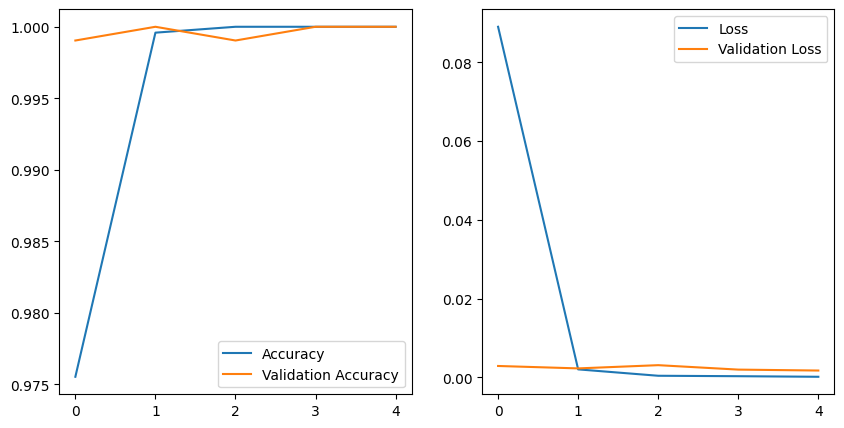

In [11]:
#Accuracy,Val accuracy, loss and val loss graphs
acc = history.history['accuracy']
val_acc =  history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Accuracy')
plt.plot(epochs_range,val_acc,label="Validation Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Loss')
plt.plot(epochs_range,val_loss,label="Validation Loss")
plt.legend()
plt.show()

In [12]:
predictions = model.predict(test_generator)
binary_predictions = (predictions > 0.5).astype(int).flatten()

true_labels = test_generator.classes

33/33 [==============================] - 9s 257ms/step


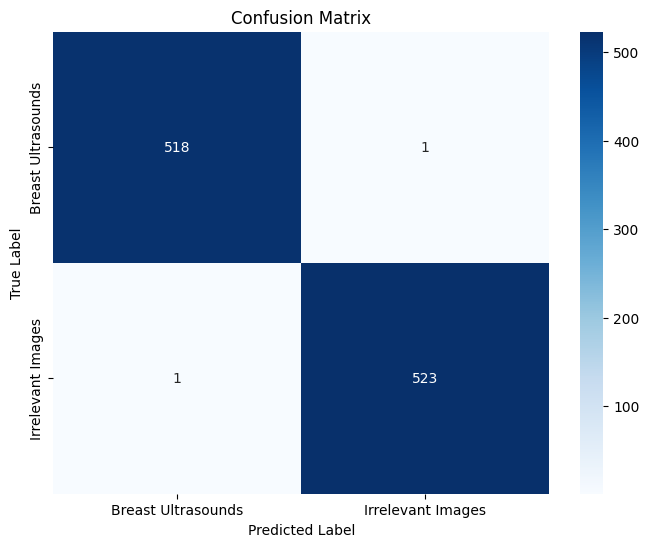

In [13]:
#Confussion matrix
cm = confusion_matrix(true_labels, binary_predictions)

#Confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Breast Ultrasounds', 'Irrelevant Images'], yticklabels=['Breast Ultrasounds', 'Irrelevant Images'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [14]:
from keras.preprocessing import image
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224,224))  # Adjust target size as needed
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize pixel values
    return img_array

def predict_single_image(model, image_path):
    processed_image = preprocess_image(image_path)
    prediction = model.predict(processed_image)
    return prediction

In [17]:
image_path = '../final_dataset1/breast_ultrasounds/benign (4).png'  # Replace with the actual image filename
prediction = predict_single_image(model, image_path)
prediction

1/1 [==============================] - 0s 27ms/step


array([[1.6634372e-12]], dtype=float32)

INFO:tensorflow:Assets written to: convnet/assets


INFO:tensorflow:Assets written to: convnet/assets
